<a href="https://colab.research.google.com/github/taylor33189-beep/Taylor_Hoskins_Repository/blob/main/Permutation_Test_ANOVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 1. Initial Check (Standard ANOVA) ---
Global Null Hypothesis (H0): Average folate levels are SAME across ALL three groups.
Global Alternative Hypothesis (Ha): Average folate levels are DIFFERENT for at least one group.

Observed F-statistic: 3.7113
Classical P-value: 4.35893e-02

Classical Conclusion: Since P-value is tiny, **REJECT H0** (Difference is real).

--- 2. Permutation Test ---


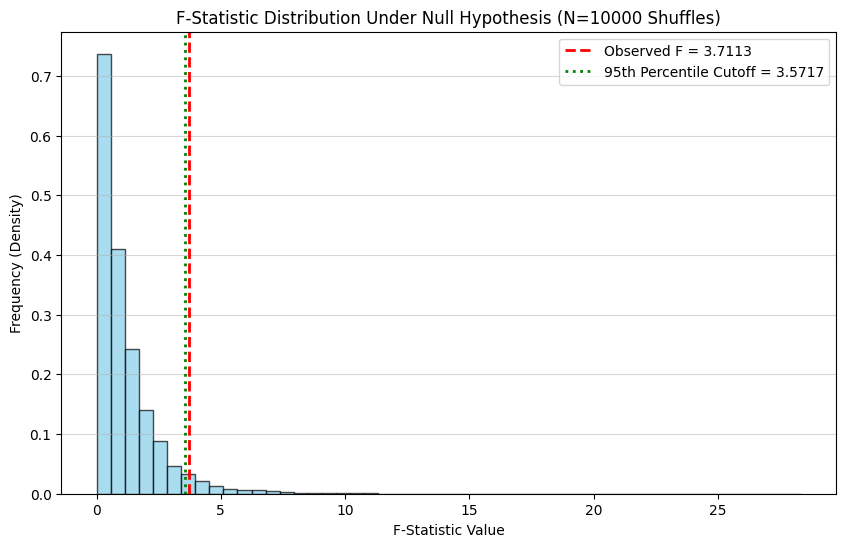


--- Histogram Result ---
Random cutoff for significance (95th percentile): 3.5717
Comment: Observed F-statistic (3.7113) > random cutoff. Confidence in real difference.

--- Permutation P-value Result ---
Empirical P-value: 4.54000e-02
Cutoff (alpha): 0.05

FINAL CONCLUSION:
Permutation P-value (4.54000e-02) < 0.05, **REJECT Null Hypothesis**.
Permutation test confirms significant difference in red cell folate levels among treatment groups.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# --- Configuration ---
N_PERMUTATIONS = 10000  # Shuffle the data 10,000 times
ALPHA = 0.05            # Standard cut-off for significance

# --- Data Loading and Preparation ---
try:
    df = pd.read_csv('amess.csv')
except FileNotFoundError:
    print("Error: 'amess.csv' not found.")
    exit()

# Rename the treatment column and define it as a factor
df.rename(columns={'treatmnt': 'treatment'}, inplace=True)
df['treatment'] = df['treatment'].astype('category')

# Shorter, simpler labels for the output
treatment_labels = {
    1: 'N2O-Cont',      # N2O continuously for 24 hours
    2: 'N2O-Op',        # N2O only during the operation
    3: 'O2-Control'     # Control (no N2O)
}
df['treatment_label'] = df['treatment'].map(treatment_labels)
# Separate the folate data into the three treatment groups
data_groups = [df[df['treatment_label'] == label]['folate'].values for label in treatment_labels.values()]


# --- Function to Calculate the F-statistic ---
def calculate_f_statistic(groups):
    """Calculates the standard F-statistic to measure group differences."""
    # F-statistic measures how much the group averages differ relative to the spread within the groups
    f_stat, _ = stats.f_oneway(*groups)
    return f_stat

# --- 1. Standard ANOVA and Global Hypothesis ---
print("--- 1. Initial Check (Standard ANOVA) ---")

# State the global null hypothesis simply
print("Global Null Hypothesis (H0): Average folate levels are SAME across ALL three groups.")
print("Global Alternative Hypothesis (Ha): Average folate levels are DIFFERENT for at least one group.")

# Perform standard ANOVA to get the observed F-statistic
model = ols('folate ~ treatment_label', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
f_observed = anova_table.loc['treatment_label', 'F']
p_classical = anova_table.loc['treatment_label', 'PR(>F)']

print(f"\nObserved F-statistic: {f_observed:.4f}")
print(f"Classical P-value: {p_classical:.5e}")
print("\nClassical Conclusion: Since P-value is tiny, **REJECT H0** (Difference is real).")

print("\n" + "="*70)

# --- 2. Permutation F Test (The Main Event) ---
print("--- 2. Permutation Test ---")

# Combine all folate data into a single pool for shuffling
folate_pool = df['folate'].values
n_per_group = [len(g) for g in data_groups] # Store original group sizes (8, 9, 5)

f_statistics_permuted = []

# Perform permutations
for _ in range(N_PERMUTATIONS):
    # 1. Shuffle the data: This simulates what the data would look like if treatments didn't matter (H0 is true)
    np.random.shuffle(folate_pool)

    # 2. Re-assign the shuffled data back into the original group sizes
    perm_group1 = folate_pool[0:n_per_group[0]]
    perm_group2 = folate_pool[n_per_group[0]:n_per_group[0]+n_per_group[1]]
    perm_group3 = folate_pool[n_per_group[0]+n_per_group[1]:]

    perm_groups = [perm_group1, perm_group2, perm_group3]

    # 3. Calculate the F-statistic for this random (null) arrangement
    f_permuted = calculate_f_statistic(perm_groups)
    f_statistics_permuted.append(f_permuted)


# --- Histogram and Rejection Region ---
plt.figure(figsize=(10, 6))
plt.hist(f_statistics_permuted, bins=50, density=True, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(f_observed, color='red', linestyle='--', linewidth=2, label=f'Observed F = {f_observed:.4f}')

# The critical value is the 95th percentile (upper 5% cut-off) of the random distribution
critical_value = np.percentile(f_statistics_permuted, 100 * (1 - ALPHA))
plt.axvline(critical_value, color='green', linestyle=':', linewidth=2, label=f'95th Percentile Cutoff = {critical_value:.4f}')

plt.title(f'F-Statistic Distribution Under Null Hypothesis (N={N_PERMUTATIONS} Shuffles)')
plt.xlabel('F-Statistic Value')
plt.ylabel('Frequency (Density)')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show() # Display the histogram

print("\n--- Histogram Result ---")
print(f"Random cutoff for significance (95th percentile): {critical_value:.4f}")

# Comment on rejection based on the histogram
if f_observed > critical_value:
    print(f"Comment: Observed F-statistic ({f_observed:.4f}) > random cutoff. Confidence in real difference.")
else:
    print("Comment: Observed F-statistic <= random cutoff. Fail to find a real difference.")


# --- Empirical P-value Calculation ---
# P-value is the proportion of shuffles that produced a difference (F-stat) as big or bigger than ours
p_empirical = np.sum(np.array(f_statistics_permuted) >= f_observed) / N_PERMUTATIONS

print("\n--- Permutation P-value Result ---")
print(f"Empirical P-value: {p_empirical:.5e}")
print(f"Cutoff (alpha): {ALPHA:.2f}")

# Final Conclusion based on the permutation p-value
if p_empirical < ALPHA:
    print(f"\nFINAL CONCLUSION:")
    print(f"Permutation P-value ({p_empirical:.5e}) < 0.05, **REJECT Null Hypothesis**.")
    print("Permutation test confirms significant difference in red cell folate levels among treatment groups.")
else:
    print(f"\nFINAL CONCLUSION:")
    print(f"Permutation P-value ({p_empirical:.5e}) >= 0.05, **DO NOT REJECT Null Hypothesis**.")
    print("Permutation test does not find significant difference in red cell folate levels among treatment groups.")